In [2]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D
from tensorflow.keras.layers import BatchNormalization,Activation,MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model


from IPython.display import SVG, Image

import tensorflow as tf
print('Tensorflow version', tf.__version__)




/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Tensorflow version 2.13.0


In [4]:
"""import os

# Specify the path to the directory you want to change to
new_directory = "F:\Emotion_Detector"

# Change the current working directory
os.chdir(new_directory)

# Verify the change
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")"""


'import os\n\n# Specify the path to the directory you want to change to\nnew_directory = "F:\\Emotion_Detector"\n\n# Change the current working directory\nos.chdir(new_directory)\n\n# Verify the change\ncurrent_directory = os.getcwd()\nprint(f"Current working directory: {current_directory}")'

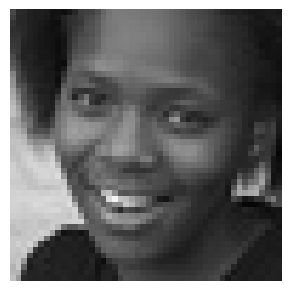

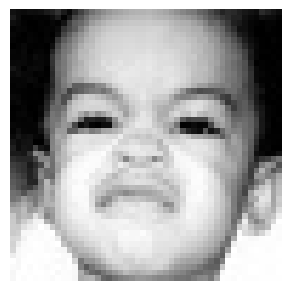

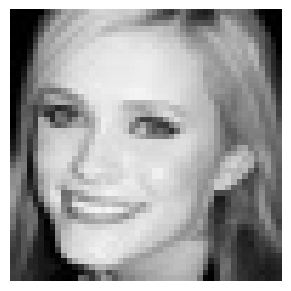

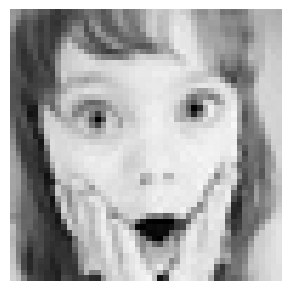

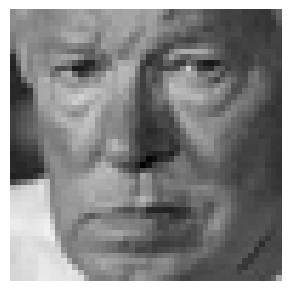

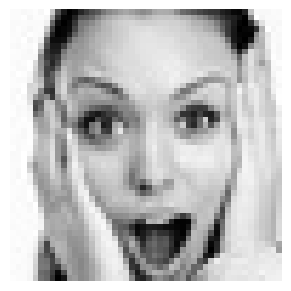

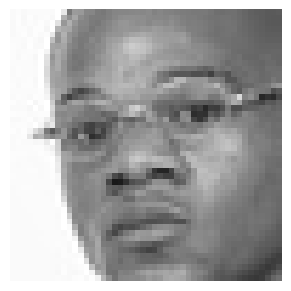

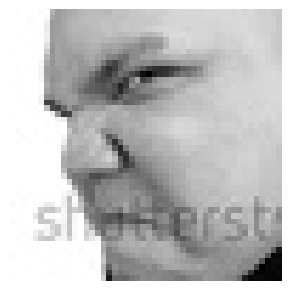

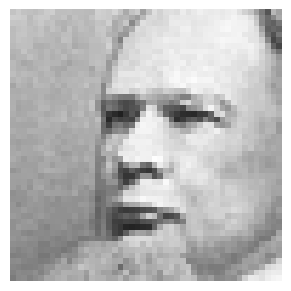

In [5]:
images = glob("/kaggle/input/fer2013/train/**/**")

if not images:
    print("Error: No images found.")
else:
    for i in range(9):
        image = random.choice(images)
        plt.figure(figsize=(12,12))
        plt.subplot(331 + i)
        plt.imshow(cv2.imread(image))
        plt.axis('off')
        plt.show()

# Data Processing

In [6]:
img_size = 48
batch_size = 64
datagen_train = ImageDataGenerator(horizontal_flip= True)

train_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/train/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip= True)
validation_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/test/",
                                                   target_size = (img_size,img_size),
                                                   color_mode = 'grayscale',
                                                   batch_size = batch_size,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model

In [7]:
def Convolution(input_tensor,filters,kernel_size):
    x = Conv2D(filters=filters, kernel_size= kernel_size,padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [8]:
def Dense_f(input_tensor,nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    
    return x
    

In [9]:
def model_fer(input_shape):
    inputs=Input(input_shape)
    conv_1=Convolution(inputs,32,(3,3))
    conv_2=Convolution(conv_1,64,(5,5))
    conv_3=Convolution(conv_2,128,(3,3))

    flatten=Flatten()(conv_3)

    dense_1=Dense_f(flatten,256)

    output=Dense(7,activation="softmax")(dense_1)
    model=Model(inputs=[inputs],outputs=[output])

    model.compile(loss=['categorical_crossentropy'],optimizer='adam',metrics=['accuracy'])
    return model

In [10]:
model = model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0     

**Initiallizing Model

In [11]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor = "val_accuracy" , save_weights_only = True, mode = "max", verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = "val_loss" , factor= 0.1, patience = 2, min_lr = 0.00001)
callbacks = [checkpoint,reduce_lr]

# Training Model

In [12]:
history = model.fit(
x = train_generator,
steps_per_epoch = steps_per_epoch,
epochs = epochs,
validation_data = validation_generator,
validation_steps= validation_steps,
callbacks = callbacks)

Epoch 1/15


2024-01-14 17:35:48.373918: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


448/448 [==============================] - ETA: 0s - loss: 1.6816 - accuracy: 0.3622
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 200s 430ms/step - loss: 1.6816 - accuracy: 0.3622 - val_loss: 1.5174 - val_accuracy: 0.4342 - lr: 0.0010
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.4067 - accuracy: 0.4621
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 52s 117ms/step - loss: 1.4067 - accuracy: 0.4621 - val_loss: 1.2895 - val_accuracy: 0.5099 - lr: 0.0010
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.2998 - accuracy: 0.5074
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 52s 117ms/step - loss: 1.2998 - accuracy: 0.5074 - val_loss: 1.3452 - val_accuracy: 0.4851 - lr: 0.0010
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.2427 - accuracy: 0.5287
Epoch 4: saving model to model_weights.h5
448/448 [========

**Model Evaluation

In [17]:
 model.evaluate(validation_generator)

113/113 [==============================] - 11s 94ms/step - loss: 1.1019 - accuracy: 0.5880


[1.1019293069839478, 0.5880467891693115]

Plotting Loss

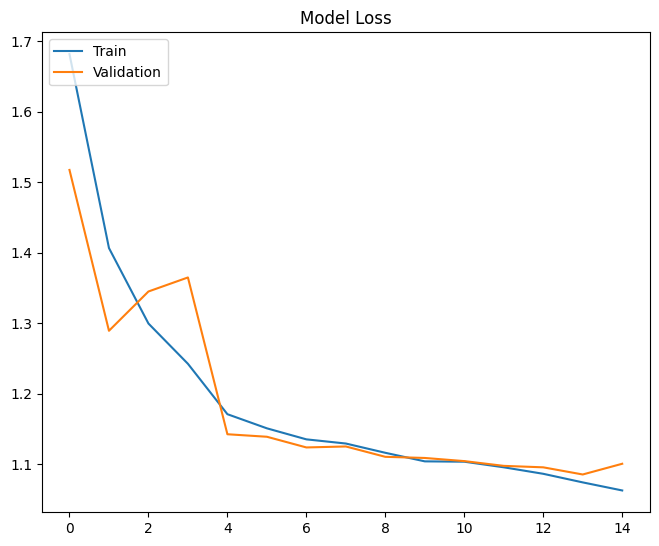

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.legend(["Train","Validation"],loc =  "upper left")
plt.subplots_adjust(top =1.0,bottom=0.0,right=0.95,left = 0.0,hspace=0.25,wspace=0.35)

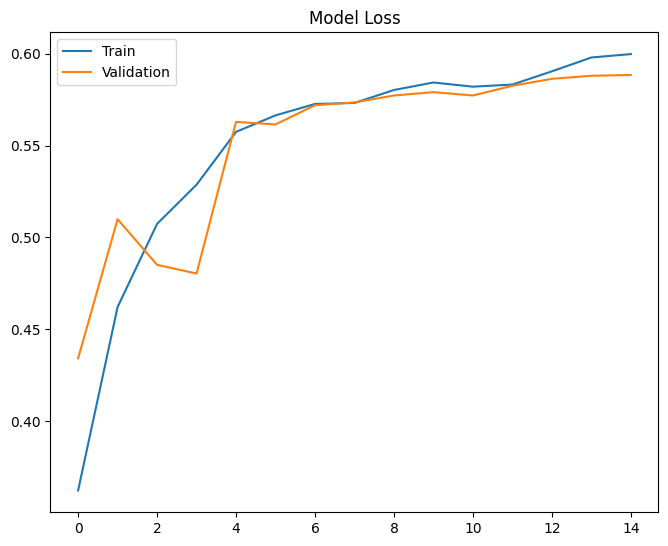

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Loss")
plt.legend(["Train","Validation"],loc =  "upper left")
plt.subplots_adjust(top =1.0,bottom=0.0,right=0.95,left = 0.0,hspace=0.25,wspace=0.35)

In [19]:
model_json = model.to_json()
with open("model_a.json","w") as json_file:
    json_file.write(model_json)